In [34]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline



import os, math
import joblib
from joblib import Parallel, delayed
from collections import Counter, defaultdict

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import cvxpy as cp
import networkx as nx
import torch, wandb

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans


import pytorch_lightning as pl
pl.utilities.seed.seed_everything(seed=0)

import matplotlib
from matplotlib import rc, ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

rc('text', usetex=True)
rc('font', family='serif')

# OWN MODULES
from src.data.data_module import UNOSDataModule, UKRegDataModule, UNOS2UKRegDataModule
from src.models.organsync import OrganSync_Network

In [122]:
# DATA PARAMS
data = 'UKReg'
batch_size = 256
synth=False
# MODEL PARAMS
model_id ='8298slm5'
# model_id UKReg (ss):   ei6zmyb1
# model_id U2U (ss):     m5ox0oau
# model_id UKreg (fact): 8298slm5
# model_id U2U (fact):   o2r2mfta


# LOAD DATA
if data == 'UNOS':
    project = 'organsync-net'
    data_dir = '../data/processed'
    dm = UNOSDataModule(data_dir, batch_size=batch_size, is_synth=synth)
elif data == 'U2U':
    project = 'organsync-net-u2u'
    data_dir = '../data/processed_UNOS2UKReg_no_split'
    dm = UNOS2UKRegDataModule(data_dir, batch_size=batch_size, is_synth=synth)
    dm.prepare_data()
else:
    project = 'organsync-net-ukreg'
    data_dir = '../data/processed_UKReg/clinical_ukeld_2_ukeld'
    dm = UKRegDataModule(data_dir, batch_size=batch_size, is_synth=synth)
    dm.prepare_data()

dm.setup(stage='test')
dm.setup(stage='fit')    

# LOAD MODELS
try:
    params = wandb.restore(f'organsync_net.ckpt.ckpt', run_path=f'jeroenbe/{project}/{model_id}', replace=True)
except:
    params = wandb.restore(f'organsync_net.ckpt-v0.ckpt', run_path=f'jeroenbe/{project}/{model_id}', replace=True)
model = OrganSync_Network.load_from_checkpoint(params.name).double()


/Users/jeroenberrevoets/.virtualenvs/organsync/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:
# REPRESENTATION FROM DATA
resolution_k  = 10
n_per_cluster = 50

n = 1000

X, O, Y, _ = dm.train_dataloader().dataset.dataset.tensors
X_t, O_t, Y_t, _ = dm.test_dataloader().dataset.tensors

with torch.no_grad():
    U = model.representation(torch.cat((X, O), dim=1))
    u = model.representation(torch.cat((X_t, O_t), dim=1))

cluster= KMeans(n_clusters=resolution_k)

cluster.fit(U)

print('Size of c(U):', Counter(cluster.labels_))

Size of c(U): Counter({0: 2705, 4: 1751, 3: 1682, 6: 1679, 8: 1563, 1: 1439, 2: 1285, 5: 1272, 9: 943, 7: 119})


In [7]:
# SELECT PATIENTS FROM CLUSTERS
# this is done on the test set

patients = np.empty((0, n_per_cluster), dtype=int)

cluster_labels = np.arange(0, resolution_k, 1)
test_cluster_labels = cluster.predict(u)

for label in cluster_labels:
    patients_of_label = np.where(test_cluster_labels == label)[0]
    patients_in_label = patients_of_label[np.random.randint(0, len(patients_of_label), (n_per_cluster,))]
    
    patients = np.append(patients, patients_in_label.reshape(1, -1), axis=0)

In [8]:
# PER CLUSTER BUILD u
u_per_cluster = np.empty((0, n_per_cluster, model.output_dim))

for ps in patients:
    u_per_cluster = np.append(u_per_cluster, u[ps].view(1, n_per_cluster, -1), axis=0)


In [9]:
# a_s per model -> (resolution_k, n_per_cluster, len(U)) => per (cluster, patient, a_s)
A_s = np.empty((0, n_per_cluster, n))
U_limited_indices = torch.randint(0, len(U), (n,))
U_limited = U[U_limited_indices]
U_labels = cluster.predict(U_limited)

In [10]:
# PER CLUSTER COMPUTE a
# NOTE: this cell comprises the bulk of 
#   the computation; might run long.

lambda_ = .1

def convex_opt(u, U, lambd):
    a = cp.Variable(U.shape[0])

    objective = cp.Minimize(cp.norm2(a@U - u)**2 + lambd * cp.norm1(a))
    constraints = [0 <= a, a <= 1, cp.sum(a) == 1]
    prob = cp.Problem(objective, constraints)

    _ = prob.solve(warm_start=True, solver=cp.SCS)

    return a.value

print('-- STARTING --')

for i, u_s_in_cluster in enumerate(u_per_cluster):
    a = Parallel(n_jobs=joblib.cpu_count())(delayed(convex_opt)(u_, U_limited, lambda_) for u_ in u_s_in_cluster)
    A_s = np.append(A_s, np.array(a)[:].reshape(1, n_per_cluster, -1), axis=0)
    print(f'---- finished cluster {i}')
print('-- FINISHED --')


-- STARTING --
---- finished cluster 0
---- finished cluster 1
---- finished cluster 2
---- finished cluster 3
---- finished cluster 4
---- finished cluster 5
---- finished cluster 6
---- finished cluster 7
---- finished cluster 8
---- finished cluster 9
-- FINISHED --


In [185]:
# BUILD MATRIX FROM a
#    INFO: every cluster connects to every other cluster.
#      On each row, there is the amount of the column
#      the cluster has on other clusters.
threshold = 1e-2


M = np.empty((resolution_k, resolution_k))

filtered = np.where(A_s >= threshold, A_s, np.zeros(A_s.shape))

for i, r in enumerate(M):
    sample_U = np.repeat(U_labels[np.newaxis, :], n_per_cluster, axis=0)

    sample = sample_U[filtered[i,:,:].astype(bool)]

    unique, counts = np.unique(sample, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    
    M[i, list(label_distribution.keys())] = list(label_distribution.values())

M = normalize(M, axis=1, norm='l1')

[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


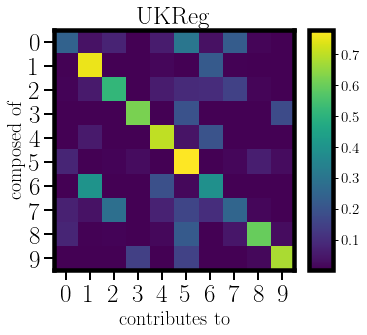

In [186]:
# PLOT MATRIX (XO)
def plot_matrix(m, require_colorbar, title):
    rc('axes', linewidth= 4.5) 

    require_colorbar = True

    fig, ax = plt.subplots(figsize=(5,5))

    ax.set_yticks(np.arange(0,resolution_k, 1))
    ax.set_yticklabels(np.arange(0, resolution_k, 1), fontsize=25)
    ax.set_xticks(np.arange(0,resolution_k, 1))
    ax.set_xticklabels(np.arange(0, resolution_k, 1), fontsize=25)

    ax.set_ylabel('composed of',  fontsize=20)
    ax.set_xlabel('contributes to',  fontsize=20)

    ax.tick_params(length=10, width=2)    

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    im = ax.imshow(m)

    divider = make_axes_locatable(ax)


    ax.set_title(title, fontsize=25)

    if require_colorbar:
        cax = divider.append_axes("right", size='10%', pad=.2)
        cax.tick_params(length=5, width=1)
        
        print(cax.yaxis.get_ticklabels())

        fig.colorbar(im, cax=cax, ticks=np.arange(0, M.max(), .1))
        cax.set_yticklabels(["{:.1f}".format(i) for i in np.arange(0, M.max(), .1)], fontsize=15)
        
    return fig

f = plot_matrix(M, True, 'UKReg')

In [187]:
# SAVE FIGURE
# SAVE RESULTS
fig_detail='UKReg'


f.savefig(f'{fig_detail}_u_composition.pdf', bbox_inches = "tight")
np.save(f'{fig_detail}_M', M)



[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


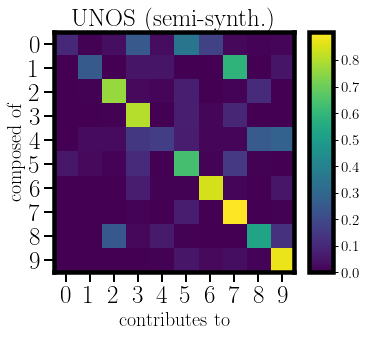

In [155]:
fig_name='UNOS (semi-synth.)'
name='UNOS_ss'

M_l = np.load(f'./{name}_M.npy')
f = plot_matrix(M_l, True, fig_name)
f.savefig(f'{name}_u_composition.pdf', bbox_inches = "tight")

In [126]:
# SINGLE EXAMPLE
threshold = 1e-2

# GET LATEST PATIENT (in regyr)
tmp = dm._test_processed.copy(deep=True)
tmp.loc[:,dm.real_cols] = dm.scaler.inverse_transform(tmp[dm.real_cols])
patient_index = 2266#tmp.regyr.argmax()

X, O, _, d = dm.test_dataloader().dataset[patient_index]
row = dm._test_processed.iloc[[patient_index]].copy(deep=True)
row[dm.real_cols] = dm.scaler.inverse_transform(row[dm.real_cols])

with torch.no_grad():
    u_single = model.representation(torch.cat((X, O), dim=0).view(1, -1).double())

a = convex_opt(u_single.flatten(), U_limited, lambda_)
a_filtered = np.where(a >= threshold, a, np.zeros(a.shape))
a_filtered_indices = np.nonzero(a_filtered)[0]

contributors = dm._train_processed.iloc[a_filtered_indices].copy(deep=True)
contributors.loc[:, dm.real_cols] = dm.scaler.inverse_transform(contributors[dm.real_cols])

contributors['contribution'] = a_filtered[a_filtered_indices]


row.SERUM_BILIRUBIN = np.exp(row.SERUM_BILIRUBIN)
row.SERUM_CREATININE = np.exp(row.SERUM_CREATININE)

contributors.SERUM_BILIRUBIN = np.exp(contributors.SERUM_BILIRUBIN)
contributors.SERUM_CREATININE = np.exp(contributors.SERUM_CREATININE)

/Users/jeroenberrevoets/.virtualenvs/organsync/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [127]:
# EXAMPLE
row

,PRIMARY_LIVER_DISEASE,reg_age,SERUM_CREATININE,SERUM_BILIRUBIN,INR,SERUM_SODIUM,regyr,rwtime,BILIR_SOD,BILIR_DG,...,DCOD_71,DCOD_72,DCOD_81,DCOD_82,DCOD_85,DCOD_88,DCOD_90,DCOD_98,DCOD_99,Y
18004,472.0,23.0,46.0,169.0,1.1,140.0,2020.0,0.0,718.18582,2421.312193,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0


In [128]:
# CONTRIBUTORS
contributors.sort_values(by='contribution', ascending=False)

,PRIMARY_LIVER_DISEASE,reg_age,SERUM_CREATININE,SERUM_BILIRUBIN,INR,SERUM_SODIUM,regyr,rwtime,BILIR_SOD,BILIR_DG,...,DCOD_72,DCOD_81,DCOD_82,DCOD_85,DCOD_88,DCOD_90,DCOD_98,DCOD_99,Y,contribution
8607,419.0,60.0,112.000000,17.000000,1.100000,129.000000,2009.0,28.0,365.484521,1187.116391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3553.0,0.575027
1468,414.0,50.0,112.108872,62.264674,1.414096,129.222581,1997.0,2.0,533.442502,1691.723093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,314.0,0.142720
13398,419.0,59.0,80.000000,80.000000,1.300000,138.000000,2015.0,165.0,604.719676,1836.069160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1589.0,0.142720
13654,419.0,64.0,88.000000,100.000000,1.900000,123.000000,2015.0,6.0,566.435933,1929.566308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1322.0,0.063004
6356,411.0,35.0,67.000000,70.000000,1.100000,141.000000,2005.0,322.0,599.037829,1746.131544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1936.0,0.051842
15680,426.0,62.0,155.000000,44.000000,1.300000,132.000000,2017.0,5.0,499.513032,1612.064784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,560.0,0.051842


In [17]:
contributors.contribution.to_numpy() @ contributors.Y.to_numpy()

2928.450680772029

In [123]:
D = dm._test_processed.copy(deep=True)

D[dm.real_cols] = dm.scaler.inverse_transform(dm._test_processed[dm.real_cols])
D.SERUM_BILIRUBIN = np.exp(D.SERUM_BILIRUBIN)
D.SERUM_CREATININE = np.exp(D.SERUM_CREATININE)

In [124]:
D[(D.SERUM_SODIUM == 140) & (D.regyr == 2020)]

,PRIMARY_LIVER_DISEASE,reg_age,SERUM_CREATININE,SERUM_BILIRUBIN,INR,SERUM_SODIUM,regyr,rwtime,BILIR_SOD,BILIR_DG,...,DCOD_71,DCOD_72,DCOD_81,DCOD_82,DCOD_85,DCOD_88,DCOD_90,DCOD_98,DCOD_99,Y
17996,426.0,66.0,100.0,48.0,0.9,140.0,2020.0,4.0,541.968142,1649.131631,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0
18004,472.0,23.0,46.0,169.0,1.1,140.0,2020.0,0.0,718.185820,2421.312193,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
17961,426.0,59.0,64.0,20.0,1.0,140.0,2020.0,0.0,419.402518,1276.181949,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0


In [125]:
D.index.get_loc(18004)

2266

In [94]:
D.loc[18004]

PRIMARY_LIVER_DISEASE    472
reg_age                   23
SERUM_CREATININE          46
SERUM_BILIRUBIN          169
INR                      1.1
                        ... 
DCOD_88                   -1
DCOD_90                   -1
DCOD_98                   -1
DCOD_99                   -1
Y                          0
Name: 18004, Length: 91, dtype: object